<function matplotlib.pyplot.show(close=None, block=None)>

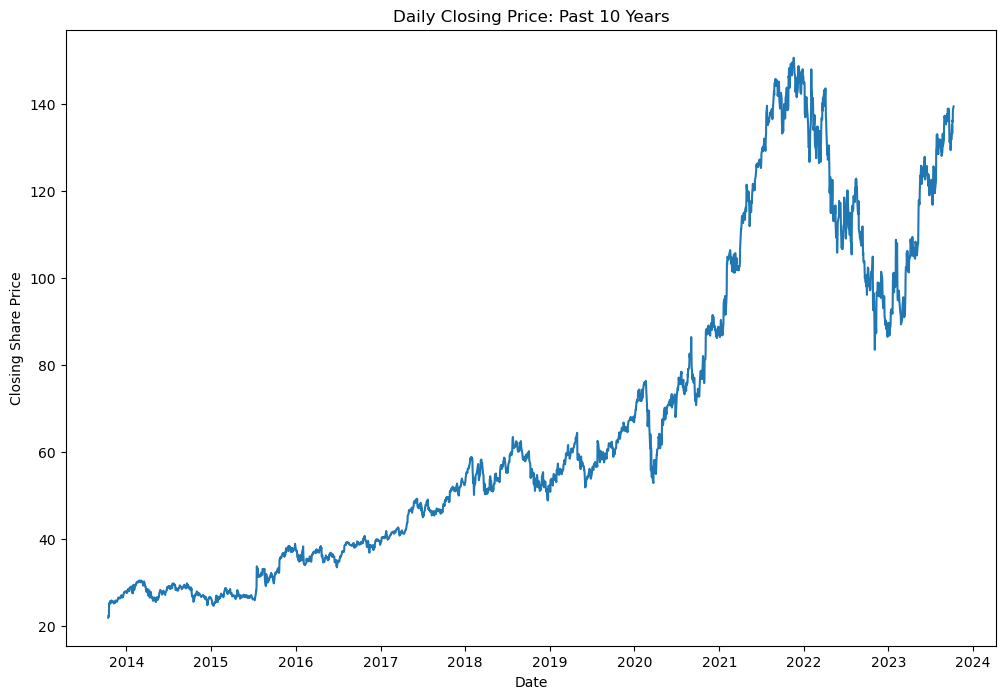

In [118]:
import datetime
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib as mpl
# for changing the plot size in the Jupyter Notebook output
%matplotlib inline
# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

end = datetime.datetime(2023, 10, 10)
start = end - datetime.timedelta(days = 10*365)

# gets the closing price for Google for the past 10 years
stock = yf.Ticker('GOOG')
stock = pd.DataFrame(stock.history(start = start, end = end)['Close'])
stock = stock.rename(str.lower, axis = 'columns')

# take the last 500 observations, which will be reduced to 250 for the purpose of fitting a
# distribution for Monte Carlo simulation
stock_distr_fitting = stock[-500:]
# creates a training subset missing the final 250 observations, which are being withheld
stock_train = stock[~stock.isin(stock_distr_fitting).all(1)]
# grabs the final 50 observations for a test set
stock_test = stock_distr_fitting[-250:]
# reduces the distribution fitting dataset to 250 observations
stock_distr_fitting = stock_distr_fitting[~stock_distr_fitting.isin(stock_test).all(1)]

# plots the stock weekly closing price over the past 10 years
plt.plot(stock.index, stock.close)
plt.title('Daily Closing Price: Past 10 Years')
plt.xlabel('Date')
plt.ylabel('Closing Share Price')
plt.show

In [171]:
stock_test

,close
Date,
2022-10-11 00:00:00-04:00,98.050003
2022-10-12 00:00:00-04:00,98.300003
2022-10-13 00:00:00-04:00,99.709999
2022-10-14 00:00:00-04:00,97.180000
2022-10-17 00:00:00-04:00,100.779999
...,...
2023-10-03 00:00:00-04:00,133.300003
2023-10-04 00:00:00-04:00,136.270004
2023-10-05 00:00:00-04:00,135.990005


In [107]:
stock_train

,close
Date,
2013-10-14 00:00:00-04:00,21.820959
2013-10-15 00:00:00-04:00,21.967909
2013-10-16 00:00:00-04:00,22.366913
2013-10-17 00:00:00-04:00,22.136776
2013-10-18 00:00:00-04:00,25.190828
...,...
2021-10-06 00:00:00-04:00,137.354004
2021-10-07 00:00:00-04:00,139.185501
2021-10-08 00:00:00-04:00,140.056000


In [108]:
stock_distr_fitting

,close
Date,
2021-10-13 00:00:00-04:00,137.899994
2021-10-14 00:00:00-04:00,141.412003
2021-10-15 00:00:00-04:00,141.675003
2021-10-18 00:00:00-04:00,142.960495
2021-10-19 00:00:00-04:00,143.822006
...,...
2022-10-04 00:00:00-04:00,102.410004
2022-10-05 00:00:00-04:00,102.220001
2022-10-06 00:00:00-04:00,102.239998


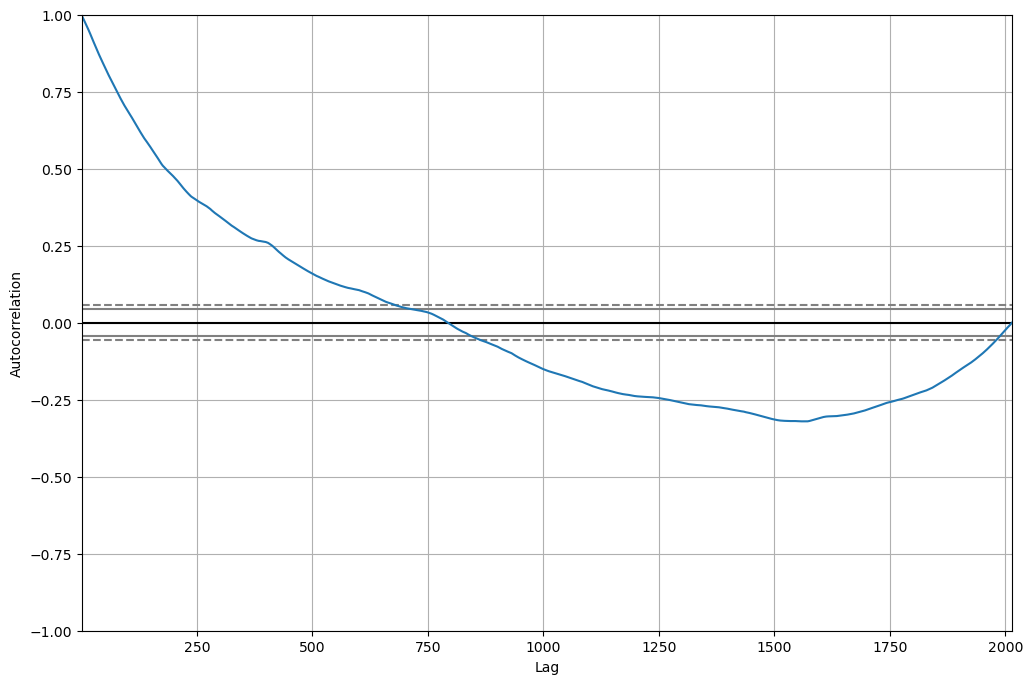

In [109]:
warnings.filterwarnings('ignore')

# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

pd.plotting.autocorrelation_plot(stock_train.close)
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

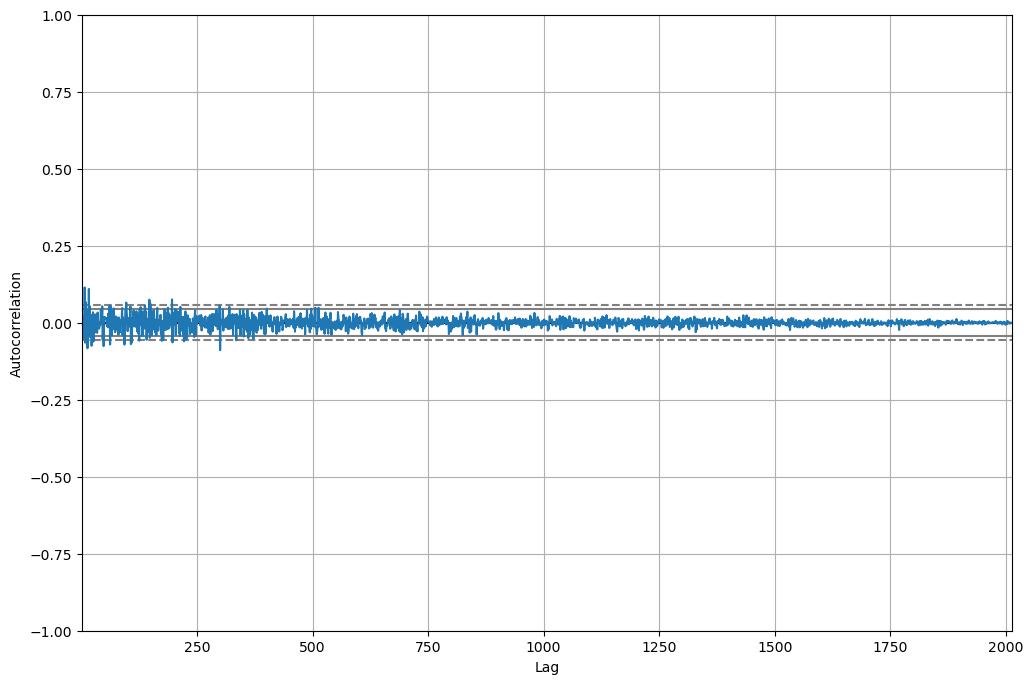

In [110]:
# plots the ACF for the differenced data over the entire train period
pd.plotting.autocorrelation_plot(stock_train.close.diff().dropna())

In [111]:
from statsmodels.tsa.stattools import adfuller

# performs ADF tests with no constant, a constant, and a constant plus linear trend on
# Google closing share prices
for i in ['nc', 'c', 'ct']:
    result = adfuller(stock_train.close, regression = i)
    print("ADF Statistic with ",i," for Closing stock price: ", result[0])
    print("p-value:", result[1])
    print()

# performs ADF tests with no constant, a constant, and a constant plus linear trend on
# differenced Google closing share prices
for i in ['nc', 'c', 'ct']:
    result = adfuller(stock_train.close.diff().dropna(), regression = i)
    print("ADF Statistic with ",i," for differenced Closing stock price: ", result[0])
    print('p-value:', result[1])
    print()

ADF Statistic with  nc  for Closing stock price:  3.8744790084259315
p-value: 0.9999996772345624

ADF Statistic with  c  for Closing stock price:  2.769431477560536
p-value: 1.0

ADF Statistic with  ct  for Closing stock price:  0.7326614463064774
p-value: 1.0

ADF Statistic with  nc  for differenced Closing stock price:  -9.133048532928676
p-value: 8.608054690090439e-16

ADF Statistic with  c  for differenced Closing stock price:  -9.468807973146175
p-value: 4.159649983992409e-16

ADF Statistic with  ct  for differenced Closing stock price:  -9.8729607123745
p-value: 4.3026737934448154e-15



In [112]:
from pmdarima import auto_arima
stepwise_fit= auto_arima(stock_train.astype(float),trace=True,supress_warning=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=1.29 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=7119.797, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=6408.335, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=6194.593, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=6057.902, Time=0.12 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=5993.405, Time=0.17 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=5955.420, Time=0.15 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.71 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.67 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=5957.417, Time=0.28 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 3.820 seconds


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 2014
Model:                 ARIMA(5, 2, 0)   Log Likelihood                5239.332
Date:                Sun, 12 Nov 2023   AIC                         -10466.665
Time:                        17:52:18   BIC                         -10433.024
Sample:                             0   HQIC                        -10454.316
                               - 2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8733      0.015    -60.022      0.000      -0.902      -0.845
ar.L2         -0.6658      0.022    -30.836      0.000      -0.708      -0.624
ar.L3         -0.4807      0.023    -21.068      0.0

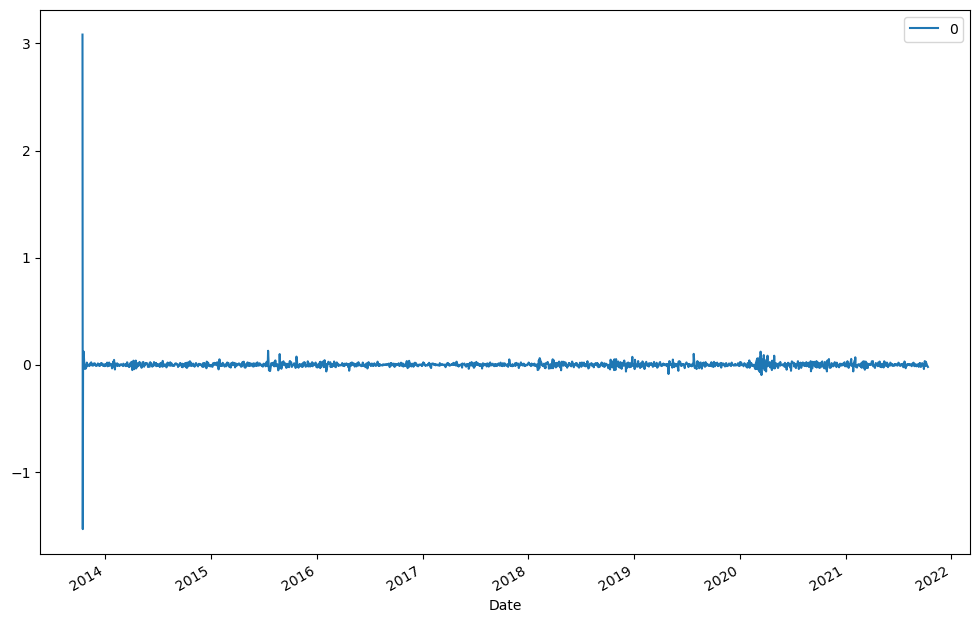

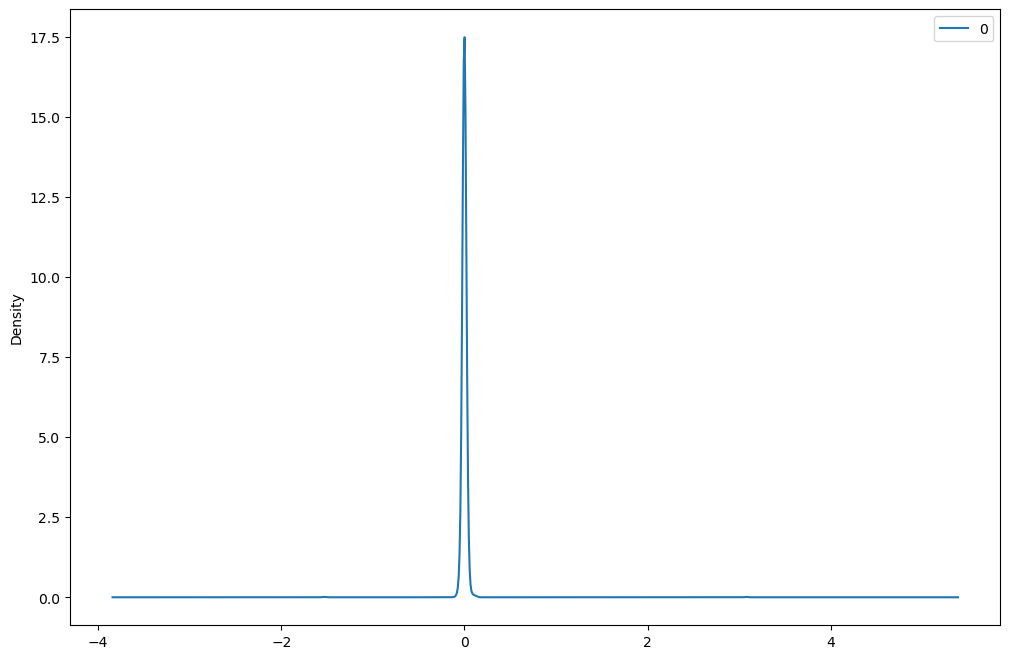

                 0
count  2014.000000
mean      0.000746
std       0.078816
min      -1.534724
25%      -0.008751
50%      -0.000632
75%       0.009050
max       3.082871


In [113]:
from statsmodels.tsa.arima.model import ARIMA

# fits the ARIMA model
stock_arima = ARIMA(np.log(stock_train.astype(float)), order = (5, 2, 0))
stock_arima_fit = stock_arima.fit()
print(stock_arima_fit.summary())

# plot residual errors of the training data
residuals = pd.DataFrame(stock_arima_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde') # kernel density estimation
plt.show()
print(residuals.describe())

In [114]:
from sklearn.metrics import mean_squared_error
# creates a new dataframe that will be added to as the forecast rolls
history = np.log(stock_train.astype(float))
# creates an empty list that will hold predictions

In [119]:
print(len(stock_distr_fitting))

250


In [120]:
warnings.filterwarnings('ignore')
predictions = []
for i in range(len(stock_distr_fitting)):
    print(i, len(predictions), len(stock_distr_fitting))
    model = ARIMA(history, order = (5,2,1),enforce_stationarity=False)
    model_fit = model.fit()
    # forecasts the next period
    output = model_fit.forecast()
    # takes the predicted value and saves it in y_pred
    y_pred = np.e ** output
    # appends y_pred to the list of predictions
    predictions.append(y_pred)
    # grabs the observation at the ith index
    obs =stock_distr_fitting[i : i + 1]
    # appends the observation to the estimation data set
    history = history.append(np.log(obs.astype(float)))

# prints the MSE of the model for the rolling forecast period
error = mean_squared_error(stock_distr_fitting, predictions)
print('Test MSE: %.3f' % error)
temp = predictions

0 0 250
1 1 250
2 2 250
3 3 250
4 4 250
5 5 250
6 6 250
7 7 250
8 8 250
9 9 250
10 10 250
11 11 250
12 12 250
13 13 250
14 14 250
15 15 250
16 16 250
17 17 250
18 18 250
19 19 250
20 20 250
21 21 250
22 22 250
23 23 250
24 24 250
25 25 250
26 26 250
27 27 250
28 28 250
29 29 250
30 30 250
31 31 250
32 32 250
33 33 250
34 34 250
35 35 250
36 36 250
37 37 250
38 38 250
39 39 250
40 40 250
41 41 250
42 42 250
43 43 250
44 44 250
45 45 250
46 46 250
47 47 250
48 48 250
49 49 250
50 50 250
51 51 250
52 52 250
53 53 250
54 54 250
55 55 250
56 56 250
57 57 250
58 58 250
59 59 250
60 60 250
61 61 250
62 62 250
63 63 250
64 64 250
65 65 250
66 66 250
67 67 250
68 68 250
69 69 250
70 70 250
71 71 250
72 72 250
73 73 250
74 74 250
75 75 250
76 76 250
77 77 250
78 78 250
79 79 250
80 80 250
81 81 250
82 82 250
83 83 250
84 84 250
85 85 250
86 86 250
87 87 250
88 88 250
89 89 250
90 90 250
91 91 250
92 92 250
93 93 250
94 94 250
95 95 250
96 96 250
97 97 250
98 98 250
99 99 250
100 100 250
101 101 

In [121]:
error = mean_squared_error(stock_distr_fitting, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 9.907


In [122]:
temp
predictions = np.array(temp)

In [123]:
predictions = pd.DataFrame(predictions)
predictions.index = stock_distr_fitting.index
predictions

,0
Date,
2021-10-13 00:00:00-04:00,113.433373
2021-10-14 00:00:00-04:00,136.484007
2021-10-15 00:00:00-04:00,143.078157
2021-10-18 00:00:00-04:00,141.507076
2021-10-19 00:00:00-04:00,142.482943
...,...
2022-10-04 00:00:00-04:00,98.562595
2022-10-05 00:00:00-04:00,102.159311
2022-10-06 00:00:00-04:00,102.244583


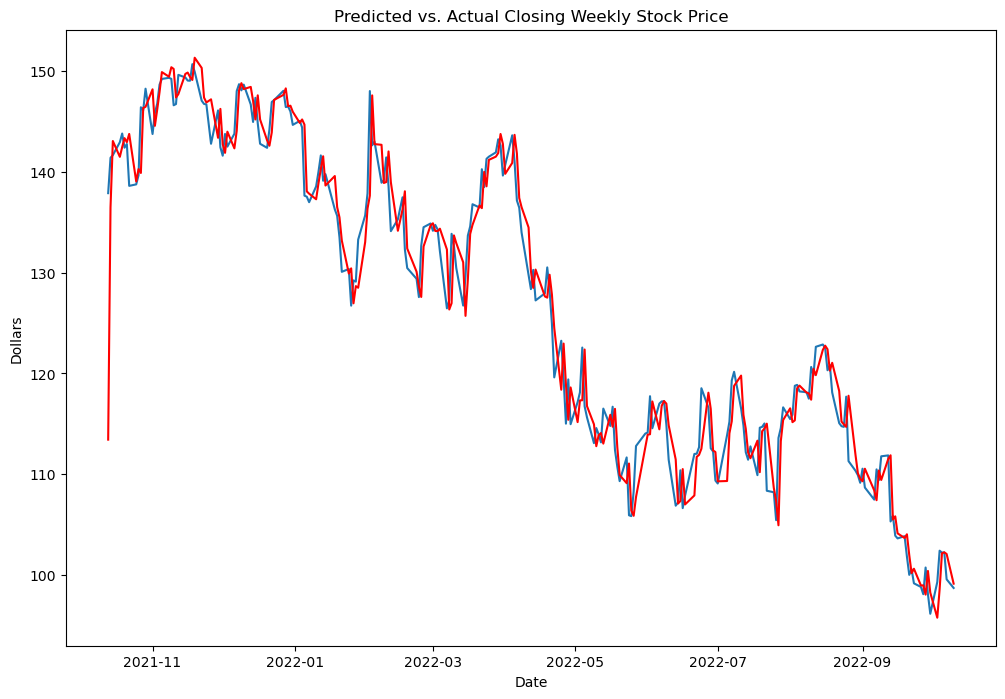

In [124]:
# plots the predicted and actual stock prices 
plt.plot(stock_distr_fitting)
plt.plot(predictions, color = 'red')
plt.xlabel('Date')
plt.ylabel('Dollars')
plt.title('Predicted vs. Actual Closing Weekly Stock Price')
plt.show()

<AxesSubplot:ylabel='Density'>

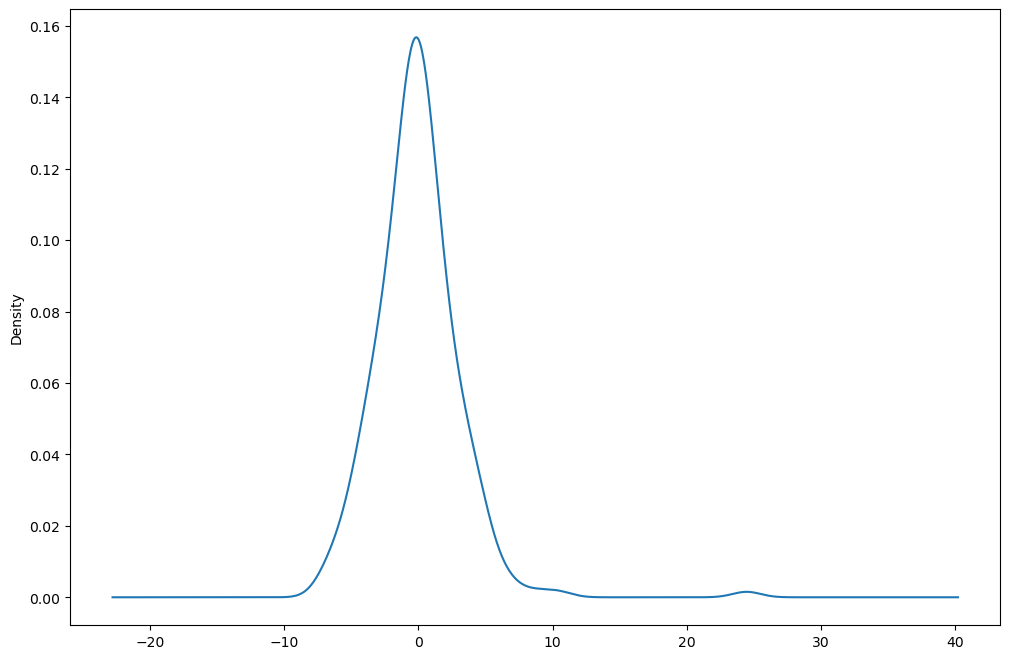

In [125]:
tune_residuals = stock_distr_fitting.close - predictions[0]
tune_residuals.plot(kind = 'kde')

In [126]:
tune_residuals.astype(float).describe()

count    250.000000
mean      -0.073649
std        3.152979
min       -7.052290
25%       -1.904923
50%       -0.198289
75%        1.347790
max       24.466620
dtype: float64

In [127]:
def laplace_monte_carlo(mean, residuals, n_sims):
    # gets the estimated beta or mean absolute distance from the mean
    beta = (sum(abs(residuals - np.mean(residuals))) / len(residuals))
    # uses the numpy function to generate an array of simulated values
    est_range = np.random.laplace(mean, beta, n_sims)
    # converts the array to a list
    est_range = list(est_range)
    # returns the simulated values
    return(est_range)

In [128]:
def roll_forecast_nmc(train, test, std_dev, n_sims):
    # creates a new dataframe that will be added to as the forecast rolls 
    history = np.log(train.astype(float))
    # creates an empty list that will store predictions
    predictions = []
    for i in range(len(test)):
        print(i)
        model = ARIMA(history, order = (5,2,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = np.e ** output
        # performs monte carlo simulation using the predicted price as the mean, user-specified
        # standard deviation, and number of simulations
        yhat_range = laplace_monte_carlo(yhat, std_dev, n_sims)
        predictions.append([float(i) for i in yhat_range])
        obs = test[i : i + 1]
        history = history.append(np.log(obs.astype(float)))

    predictions = pd.DataFrame(predictions)
    predictions.index = stock_distr_fitting.index
    predictions['predicted_range'] = predictions.values.tolist()
    predictions = pd.DataFrame(predictions['predicted_range'])
    return(predictions)

In [129]:
len(stock_test)

250

In [130]:
my_stock_train = stock_train.append(stock_distr_fitting)


# produces a rolling forecast with prediction intervals using 1000 Monte Carlo simulations
test_preds = roll_forecast_nmc(my_stock_train, stock_test, tune_residuals,1000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


In [132]:
in_prediction_interval = []
# loops through the rows in the testing data set
for i in range(len(stock_test)):
    # appends true if the actual price is in the interval of predicted prices and false
    # otherwise
    in_prediction_interval.append(np.where(min(test_preds.predicted_range[i]) <= 
                                           stock_test.close[i]
                                          <= max(test_preds.predicted_range[i]), 
                                           True, False))
# prints the percentage of actual prices in the prediction intervals    
print('Percentage of Actual Stock Prices in Predicted Stock Price Range: %f' % (100 * sum(in_prediction_interval) / len(in_prediction_interval)))

Percentage of Actual Stock Prices in Predicted Stock Price Range: 100.000000


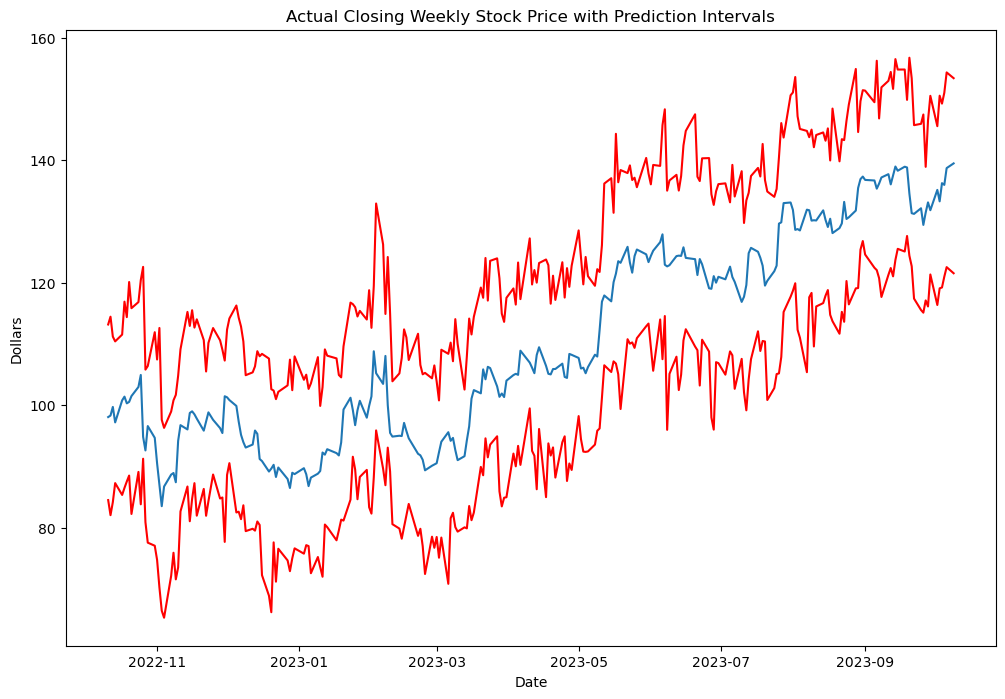

In [134]:
min_range = []
max_range = []

for i in range(len(test_preds)):
    min_range.append(min(test_preds.predicted_range[i]))
    max_range.append(max(test_preds.predicted_range[i]))

# converts the lists to data frames and makes their indexes match up with the dates they're
# predicting
min_range = pd.DataFrame(min_range)
min_range.index = stock_test.index
max_range = pd.DataFrame(max_range)
max_range.index = stock_test.index

# plots the actual stock price with prediction intervals
plt.plot(stock_test)
plt.plot(min_range, color = 'red')
plt.plot(max_range, color = 'red')
plt.xlabel('Date')
plt.ylabel('Dollars')
plt.title('Actual Closing Weekly Stock Price with Prediction Intervals')
plt.show()

In [199]:
target_price = 135
above_target = [i >= target_price for i in test_preds.predicted_range[len(test_preds) - 1]]
# prints the probability
print('Probability Actual Stock Price is above Strike Price: ' , (sum(above_target) / len(above_target)))

Probability Actual Stock Price is above Strike Price:  0.946


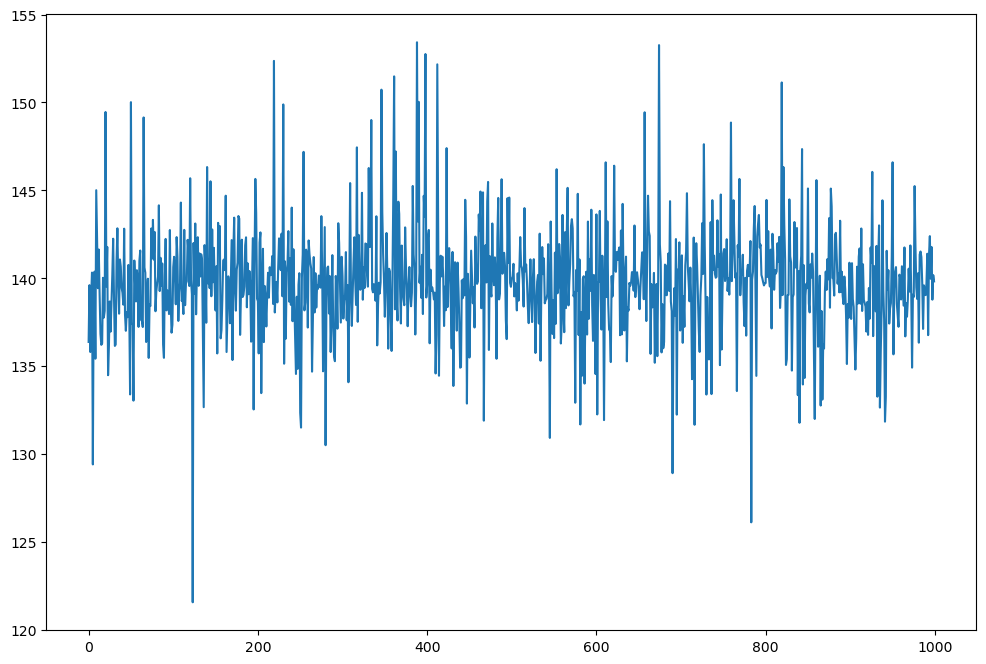

In [205]:
plt.plot(np.array(test_preds.predicted_range[-1]))

In [191]:
end_ = datetime.datetime(2023, 10, 13)
start_ = end - datetime.timedelta(days = 5)

# gets the closing price for Google for the past 10 years
stock_ = yf.Ticker('GOOG')
stock_ = pd.DataFrame(stock_.history(start = start_, end = end_)['Close'])
stock_

,Close
Date,
2023-10-05 00:00:00-04:00,135.990005
2023-10-06 00:00:00-04:00,138.729996
2023-10-09 00:00:00-04:00,139.500000
2023-10-10 00:00:00-04:00,139.199997
2023-10-11 00:00:00-04:00,141.699997
2023-10-12 00:00:00-04:00,140.289993
